In [12]:
import warnings
warnings.filterwarnings('ignore')

# import pandas as pd
# import ray
# ray.init(num_cpus=4)
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import gc

from utils.schemas import *
from utils.functions import *

In [2]:
data_folder = 'input'

In [3]:
train = pd.read_csv(data_folder+'/train_synthetic_0.csv', dtype = schema_synthetic).sort_values('TransactionDT')
test = pd.read_csv(data_folder+'/test_synthetic_0.csv', dtype = schema_synthetic).sort_values('TransactionDT')

In [4]:
train.shape, test.shape

((270901, 558), (221908, 558))

In [5]:
# train_index = train.shape[0]
# test_index = test.shape[0]
# df = pd.concat([train, test], axis=0)
# df.shape

In [6]:
old_cols = train.columns

In [7]:
# del train
# del test
# gc.collect()

In [8]:
id_cols = ['addr1', 'addr2', 'card1', 'P_emaildomain']

In [10]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_38_fe2,device_version_fe2,R_emaildomain_0_fe2,P_emaildomain_1_fe2,proc_id_30_0_fe2,proc_id_30_1_fe2,proc_id_31_0_fe2,R_emaildomain_1_fe2,P_emaildomain_0_fe2,device_name_fe2
0,0,86400,68.5,0,1749,12,0,3,35,1,...,0,0,0,1,0,0,0,0,2,0
1,0,86401,29.0,0,139,31,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,86469,59.0,0,101,3,0,0,2,0,...,0,0,0,0,0,0,0,0,8,0
3,0,86499,50.0,0,17,20,0,1,4,0,...,0,0,0,0,0,0,0,0,1,0
4,0,86506,50.0,3,5782,7,0,1,3,1,...,1,2,0,0,4,4,8,0,0,4


In [13]:
gc.collect()

0

In [16]:
def plot_col(df, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    ax.plot(df[df.isFraud == 0].TransactionDT, df[df.isFraud == 0][col])
    ax.plot(df[df.isFraud == 1].TransactionDT, df[df.isFraud == 1][col])
    ax.plot(df[df.isFraud.isna()].TransactionDT, df[df.isFraud.isna()][col])
    plt.show()
    gc.collect()

In [17]:
def plot_hist_col(df, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    ax.hist(df[df.isFraud.isna()][col], 100)
    ax.hist(df[df.isFraud == 0][col], 100)
    ax.hist(df[df.isFraud == 1][col], 100)
    plt.show()
    gc.collect()

In [18]:
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

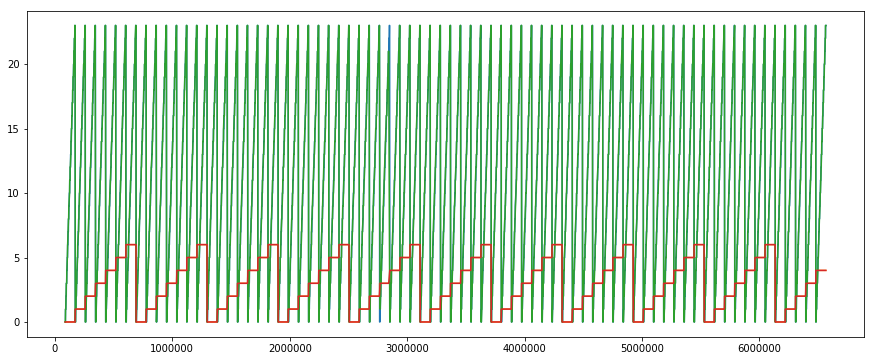

In [25]:
plot_col(train, ['Transaction_hour', 'Transaction_day_of_week'])

In [26]:
def freq_encoder2(df, label, min_freq = 0.001):
    rows = df.shape[0]
    n = 0
    dict_fe = dict()
    vc = df[label].value_counts()
    for i, j in zip(vc.index, vc):
        ratio = j/rows
        if ratio > min_freq:
            dict_fe[i] = n
            n += 1
        else:
            dict_fe[i] = n

    if n < 2**8:
        _d_type = 'uint8'
    elif n >= 2**8 and n < 8**16:
        _d_type = 'uint16'
    elif n >= 2**16 and n < 8**32:
        _d_type = 'uint32'
    else:
        _d_type = 'uint64'

#     df[new_label] = df[label].apply(lambda x: dict_fe[x]).astype(_d_type)

    return dict_fe, _d_type

def freq_encoder2_test(df, label, dict_fe):
    list_unique = df[label].unique()
    max_val = max(dict_fe.values())
    train_values = dict_fe.keys()
    for v in list_unique:
        if v not in train_values:
            dict_fe[v] = max_val+1
    
    return dict_fe

In [33]:
cols1 = [x for x in train.columns if 'card' in x and '_fe1' in x]
ft = 'N1'
train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
dict_fe, _d_type = freq_encoder2(train, ft, 0)
dict_fe_test = freq_encoder2_test(test, ft, dict_fe)
train[ft] = train[ft].apply(lambda x: dict_fe[x]).astype(_d_type)
test[ft] = test[ft].apply(lambda x: dict_fe_test[x]).astype(_d_type)

KeyError: 'N1'

In [17]:
cols1 = [x for x in df.columns if 'addr' in x]
df['N2'] = df.groupby(cols1)['TransactionDT'].transform('count').astype(np.uint32)

In [18]:
cols1 = [x for x in df.columns if 'C' in x and 'Product' not in x]
df['N3'] = df.groupby(cols1)['TransactionDT'].transform('count').fillna(df.groupby(cols1)['TransactionDT'].transform('count').isna().sum()).astype(np.uint32)

In [19]:
cols1 = [x for x in df.columns if 'mail' in x]
df['N4'] = df.groupby(cols1)['TransactionDT'].transform('count').astype(np.uint32)

In [20]:
cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1']
df['N5'] = df.groupby(cols1)['TransactionDT'].transform('count').astype(np.uint32)

In [21]:
cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1', 'card1']
df['N6'] = df.groupby(cols1)['TransactionDT'].transform('count').astype(np.uint32)

In [22]:
cols1 = ['addr1', 'addr2', 'card1', 'P_emaildomain']
df['N7'] = df.groupby(cols1)['TransactionDT'].transform('count').astype(np.uint16)

#### V columns

In [23]:
# groups V
cols1 = ['V{}'.format(x) for x in range(1,12)]
cols2 = ['V{}'.format(x) for x in range(12,35)]
cols3 = ['V{}'.format(x) for x in range(35,53)]
cols4 = ['V{}'.format(x) for x in range(53,75)]
cols5 = ['V{}'.format(x) for x in range(75,95)]
cols6 = ['V{}'.format(x) for x in range(95,138)]
cols7 = ['V{}'.format(x) for x in range(138,167)]
cols8 = ['V{}'.format(x) for x in range(167,217)]
cols9 = ['V{}'.format(x) for x in range(217,279)]
cols10 = ['V{}'.format(x) for x in range(279,322)]
cols11 = ['V{}'.format(x) for x in range(322,340)]

In [24]:
# Binary V
bin_v = ['V1', 'V14', 'V41', 'V65', 'V88', 'V107', 'V305']

In [25]:
V_cols = [cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8, cols9, cols10, cols11, bin_v]

In [26]:
df['N8'] = df.groupby(cols1)['TransactionDT'].transform('count')
df['N8'] = (df.N8/df.N8.max()).astype(np.float32).replace(np.inf, np.nan)
df['N9'] = df.groupby(cols2)['TransactionDT'].transform('count')
df['N9'] = (df.N9/df.N9.max()).astype(np.float32).replace(np.inf, np.nan)
df['N10'] = df.groupby(cols3)['TransactionDT'].transform('count')
df['N10'] = (df.N10/df.N10.max()).astype(np.float32).replace(np.inf, np.nan)
df['N11'] = df.groupby(cols4)['TransactionDT'].transform('count')
df['N11'] = (df.N11/df.N11.max()).astype(np.float32).replace(np.inf, np.nan)
df['N12'] = df.groupby(cols5)['TransactionDT'].transform('count')
df['N12'] = (df.N12/df.N12.max()).astype(np.float32).replace(np.inf, np.nan)
df['N13'] = df.groupby(cols6)['TransactionDT'].transform('count')
df['N13'] = (df.N13/df.N13.max()).astype(np.float32).replace(np.inf, np.nan)
df['N14'] = df.groupby(cols7)['TransactionDT'].transform('count')
df['N14'] = (df.N14/df.N14.max()).astype(np.float32).replace(np.inf, np.nan)
df['N15'] = df.groupby(cols8)['TransactionDT'].transform('count')
df['N15'] = (df.N15/df.N15.max()).astype(np.float32).replace(np.inf, np.nan)
df['N16'] = df.groupby(cols9)['TransactionDT'].transform('count')
df['N16'] = (df.N16/df.N16.max()).astype(np.float32).replace(np.inf, np.nan)
df['N17'] = df.groupby(cols10)['TransactionDT'].transform('count')
df['N17'] = (df.N17/df.N17.max()).astype(np.float32).replace(np.inf, np.nan)
df['N18'] = df.groupby(cols11)['TransactionDT'].transform('count')
df['N18'] = (df.N18/df.N18.max()).astype(np.float32).replace(np.inf, np.nan)
df['N19'] = df.groupby(bin_v)['TransactionDT'].transform('count')
df['N19'] = (df.N19/df.N19.max()).astype(np.float32).replace(np.inf, np.nan)
n = 20
for c in V_cols[:4]:
    df['N{}'.format(n)] = (df.groupby(c)['TransactionDT'].transform('std')/df.groupby(c)['TransactionDT'].transform('mean')).replace(np.inf, np.nan)
    n += 1
gc.collect()

8

In [27]:
df.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.000176,NaN,NaN,0.55594,0.601698,NaN,0.599398
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.728876,0.723393,0.759264
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,1.000000,NaN,1.0,0.55594,0.601698,0.595304,0.599398
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.000004,NaN,NaN,NaN,0.601698,0.595304,0.599398
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000011,1.0,1.0,0.676342,1.0,NaN,NaN,NaN,NaN,NaN


New features

In [31]:
c_cols = [x for x in df.columns if 'C' in x and x not in ['ProductCD','ProductCD_fe1','ProductCD_fe2']]

In [32]:
df['R1'] = (np.log1p(df.C13/df.C1)).replace(np.inf, np.nan)

df['R2'] = (np.log1p(df.D1/df.D15)).replace(np.inf, np.nan)

df['R3'] = (np.log1p(df.TransactionAmt/df.TransactionAmt.values.mean())).replace(np.inf, np.nan)

df['R4'] = (np.log1p(df.N3/df.N1)).replace(np.inf, np.nan)

df['R5'] = (df['D15'] / df.groupby(['card1', 'addr1'])['D15'].transform('std')).replace(np.inf, np.nan)

df['R6'] = (df['D15'] / df.groupby(['TransactionDT'])['D15'].transform('std')).replace(np.inf, np.nan)

df['R7'] = (df.TransactionAmt / df.Transaction_hour / df.Transaction_day_of_week).replace(np.inf, np.nan)

df['R8'] = (df['TransactionAmt'] / df.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

df['R9'] = (df['TransactionAmt'] / df.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

df['R10'] = (df['TransactionAmt'] / df.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

df['R11'] = (df['TransactionAmt'] / df.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

df['R12'] = (df.groupby(['card1','addr1'])['card1'].transform('mean') * df.groupby(['card1','addr1'])['card1'].transform('count')).replace(np.inf, np.nan)

df['R13'] = (df.TransactionAmt / df.groupby(['card1', 'card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

df['R14'] = (df.C2 / df.groupby(['card1', 'V258', 'D10'])['C2'].transform('mean')).replace(np.inf, np.nan)

df['R15'] = (df.V130 / df.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V130'].transform('std')).replace(np.inf, np.nan)

df['R16'] = (df.V258 / df.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V258'].transform('std')).replace(np.inf, np.nan)

df['R17'] = (df.D10 / df.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

df['R18'] = (df.D11 / df.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

df['R19'] = (df.D15 / df.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

df['R20'] = (df.D3 / df.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

df['R21'] = (df.D4 / df.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

df['R22'] = (df.D5 / df.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

df['R23'] = (df.D6 / df.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

df['R24'] = df.D7 * df.groupby(id_cols)['D7'].transform('std')
df['R24'] = df['R24'].replace(np.inf, np.nan)
df['R24'] = df['R24']/df['R24'].max()

df['R25'] = df.D12 * df.groupby(id_cols)['D12'].transform('std')
df['R25'] = df['R25'].replace(np.inf, np.nan)
df['R25'] = df['R25']/df['R25'].max()

df['R26'] = df.D6 * df.groupby(id_cols)['D6'].transform('std')
df['R26'] = df['R26'].replace(np.inf, np.nan)
df['R26'] = df['R26']/df['R26'].max()

df['R27'] = df.D8 * df.groupby(id_cols)['D8'].transform('std')
df['R27'] = df['R27'].replace(np.inf, np.nan)
df['R27'] = df['R27']/df['R27'].max()

df['R28'] = (df.TransactionAmt - df.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

df['R29'] = (df.TransactionDT - (df.TransactionDT - df.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

df['R30'] = (df.dist1 - df.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

df['R31'] = (df.dist2 - df.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

n = 32
for c in c_cols:
    df['R{}'.format(n)] = (df[c] / df.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
    n += 1

for c in c_cols:
    df['R{}'.format(n)] = (df[c] / df.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
    n += 1
    
for c in c_cols:
    df['R{}'.format(n)] = (df[c] / (df.groupby(id_cols)[c].transform('std')/df.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
    n += 1
    

In [5]:
# train = pd.read_csv(data_folder+'/train_ft_eng_0.csv', dtype = schema_generated_0)
# test = pd.read_csv(data_folder+'/test_ft_eng_0.csv', dtype = schema_generated_0)

In [33]:
dict(df.dtypes)

{'C1': dtype('float16'),
 'C10': dtype('float16'),
 'C11': dtype('float16'),
 'C12': dtype('float16'),
 'C13': dtype('float16'),
 'C14': dtype('float16'),
 'C2': dtype('float16'),
 'C3': dtype('float16'),
 'C4': dtype('float16'),
 'C5': dtype('float16'),
 'C6': dtype('float16'),
 'C7': dtype('float16'),
 'C8': dtype('float16'),
 'C9': dtype('float16'),
 'D1': dtype('float16'),
 'D10': dtype('float16'),
 'D11': dtype('float16'),
 'D12': dtype('float16'),
 'D13': dtype('float16'),
 'D14': dtype('float16'),
 'D15': dtype('float16'),
 'D2': dtype('float16'),
 'D3': dtype('float16'),
 'D4': dtype('float16'),
 'D5': dtype('float16'),
 'D6': dtype('float16'),
 'D7': dtype('float16'),
 'D8': dtype('float16'),
 'D9': dtype('float16'),
 'DeviceInfo': dtype('uint16'),
 'DeviceType': dtype('uint8'),
 'M1': dtype('uint8'),
 'M2': dtype('uint8'),
 'M3': dtype('uint8'),
 'M4': dtype('uint8'),
 'M5': dtype('uint8'),
 'M6': dtype('uint8'),
 'M7': dtype('uint8'),
 'M8': dtype('uint8'),
 'M9': dtype('uin

In [34]:
df.shape

(1097231, 656)

In [64]:
# drop_cols = ['D10', 'D11', 'D12', 'D15', 'D3', 'D4',
#             'D5', 'D6', 'D7', 'D8']

In [65]:
# df = df[[x for x in df.columns if x not in drop_cols]]

In [67]:
# df = df.replace(np.inf, np.nan)

In [35]:
train = df.iloc[:train_index, :]
test = df.iloc[train_index:, :]

In [36]:
train.to_csv(data_folder+'/train_ft_eng_2.csv', header=True, index=None)
print('train guardado')
test.to_csv(data_folder+'/test_ft_eng_2.csv', header=True, index=None)
print('test guardado')

train guardado
test guardado


In [37]:
train.shape, test.shape

((590540, 656), (506691, 656))

In [38]:
train.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,R64,R65,R66,R67,R68,R69,R70,R71,R72,R73
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.869141,1.264648,1.464844,NaN,0.0,0.0,1.304688,NaN,0.0,0.000000
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.642578,NaN,2.599609,NaN,NaN,NaN,2.599609,NaN,NaN,NaN
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,43.000000,3.142578,11.632812,NaN,0.0,NaN,10.320312,NaN,0.0,3.611328
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
